

**Data analysis**




In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

In [ ]:
train = pd.read_csv('train.csv')
train

,text,label,language
0,wearing a fake engagement ring so guys won’t a...,1.8,English
1,Bees vs. Wasps. http,1.0,English
2,Here is a nice equation: 0+0-0-0+0=0,1.0,English
3,@user @user Enjoy each new day!😊🇨🇦🐞🐭,1.6,English
4,I can be having a perfectly good day then I th...,1.6,English
...,...,...,...
9486,若被確認為「國際關注公共衛生緊急事件」， 世衛會發布一系列包括確診、隔離和治療的詳細計畫， ...,1.0,Chinese
9487,@user 是嗎？ 可能我沒有注意到吧,2.0,Chinese
9488,@user @user 你剃过毛毛吗,3.8,Chinese
9489,@user 她没说是捐吧？,1.8,Chinese


In [ ]:
test = pd.read_csv('test.csv')
test = test[test['label'] != 0.0]
test

,text,label,language,predictions,tdf-idf
0,@user 아..,3.0,Korean,1.483756,1.483756
1,@user @user je rêve ??,2.2,French,2.005481,2.005481
2,"thank u, nxt",1.0,English,2.217620,2.217620
3,@user ma che cosa HO FATTO,2.6,Italian,2.927782,2.927782
4,在教室打飞机，站累了，就搬凳子坐下，站着坐着都是你爸爸，听爸爸的话哦！骚货，爸爸爱你。 http,3.0,Chinese,3.194671,3.194671
...,...,...,...,...,...
3876,@user Não sei se ele vai terminar com a Kyra (...,3.0,Portuguese,2.751414,2.751414
3877,@user Coitada...fraquinha....Povo precisa sabe...,1.4,Portuguese,1.603758,1.603758
3878,@user أي عطر حبيبي .... مساعدة بشار البعثي عطر ؟؟,3.5,Arabic,2.031519,2.031519
3879,"TSC promoveert naar tweede klasse, ontgoocheli...",1.0,Dutch,0.756665,0.756665


In [ ]:
train = shuffle(train)
num_folds = 5
train['fold'] = np.arange(0,len(train)) % num_folds
train

,text,label,language,fold
2504,🎸 Clonación capilar: la gran novedad para los ...,1.0,Spanish,0
3772,o dia de hoje sugou toda a energia q eu ainda ...,3.0,Portuguese,1
1231,"@user @user @user Dak literally almost had 4,0...",1.5,English,2
2637,No sé si reír o llorar... 😢😂 http,1.0,Spanish,3
2282,@user Súper sarcástico y la gente ni lo coge,2.4,Spanish,4
...,...,...,...,...
4838,ecco cosa serve a quelli che ancora nel 2021 u...,3.4,Italian,1
5656,@user no ma troveranno il modo per dire che an...,1.4,Italian,2
8114,對金正賢真的是🙄管你有病還是女朋友什麼的 都不是藉口讓你對玄做那些行為吧？？？那些是作為演員...,2.2,Chinese,3
1887,Iván Duque se habría ensuciado las manos: mili...,1.2,Spanish,4


**Build model**

In [ ]:
!pip install jieba
import jieba
import jieba.posseg as pseg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Bag Of Word(BOW)s
vectorizer = CountVectorizer(ngram_range = (1,3), tokenizer=jieba.lcut)

# Tf-Idf
#vectorizer = TfidfVectorizer(ngram_range = (1,3), tokenizer=jieba.lcut)

In [ ]:
train_vectorized = vectorizer.fit_transform(train['text'])
train_vectorized

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
DEBUG:jieba:Loading model from cache /tmp/jieba.cache
Loading model cost 0.969 seconds.
DEBUG:jieba:Loading model cost 0.969 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


<9491x232022 sparse matrix of type '<class 'numpy.int64'>'
	with 578472 stored elements in Compressed Sparse Row format>

**Model training**

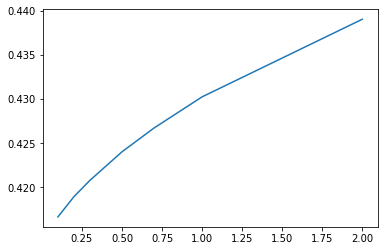

In [ ]:
cor_coef_train = []
cor_coef_validate = []
alpha = [0.1, 0.2, 0.3, 0.5, 0.7, 1, 2] # 3, 4, 5, 10]

# split data into folds for cross-validation
step = np.floor(len(train)/5)

for a in alpha: # optimize model over regularization coeficient
  error_train = 0
  error_validate = 0

  for k in range(0,num_folds): # k-fold
    # Classifier:
    #clf = LinearRegression()
    clf = Ridge(alpha = a)
    trainfeatures = vectorizer.transform(train[train['fold'] != k]['text'])
    validatefeatures = vectorizer.transform(train[train['fold'] == k]['text'])
    clf.fit(trainfeatures, train[train['fold'] != k]['label'])

    # train results
    results = clf.predict(trainfeatures)
    error_train += np.corrcoef(train[train['fold'] != k]['label'], results)[0,1]

    # validation results
    results = clf.predict(validatefeatures)
    error_validate += np.corrcoef(train[train['fold'] == k]['label'], results)[0,1]

  cor_coef_train.append(error_train/5)
  cor_coef_validate.append(error_validate/5)

#plt.plot(alpha, cor_coef_train)
plt.plot(alpha, cor_coef_validate)

**Results analysis**

In [ ]:
clf = Ridge(alpha = alpha[np.argmax(cor_coef_validate)])
clf.fit(vectorizer.transform(train['text']), train['label'])
test['predictions'] = clf.predict(vectorizer.transform(test['text']))

English 0.42998668579928995
Spanish 0.5826837146445671
Portuguese 0.4666747939747748
Italian 0.472450622632758
French 0.46114511494269406
Chinese 0.3558946168560682
Hindi 0.06885690906845406
Dutch 0.2621619193232663
Korean 0.1559550201548337
Arabic 0.31518972211736623
Overall 0.3916576803948675
Seen Languages 0.4834864565270429
Unseen Languages 0.31167354746745624
0.42999 & 0.58268 & 0.46667 & 0.47245 & 0.46115 & 0.35589 & 0.06886 & 0.26216 & 0.15596 & 0.31519
0.39166 & 0.48349 & 0.31167


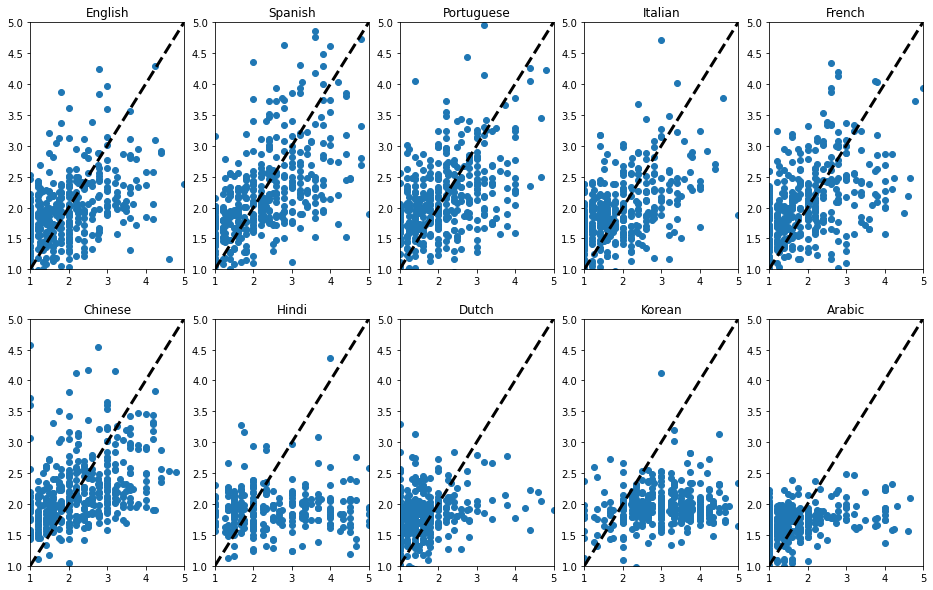

In [ ]:
languages = ['English', 'Spanish', 'Portuguese', 'Italian', 'French', 'Chinese','Hindi', 'Dutch', 'Korean', 'Arabic']
corr = []

f = plt.figure()
f.set_figwidth(16)
f.set_figheight(10)
i = 1

for language in languages:
  ind = (test['language'] == language).values
  plt.subplot(2,5,i)
  plt.scatter(test[ind]['label'], test[ind]['predictions'])
  error = np.corrcoef(test[ind]['label'], test[ind]['predictions'])[0,1]
  plt.title(language)
  print(language + ' ' + str(error))
  plt.xlim([1,5])
  plt.ylim([1,5])
  xpoints = ypoints = plt.xlim()
  plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
  i += 1
  corr.append(error)

overall = []
error = test['predictions'].corr(test['label'])
overall.append(error)
print('Overall', error)

s_df = test[test['language'].isin(['English', 'Spanish', 'Portuguese', 'Italian', 'French', 'Chinese'])]
error = s_df['predictions'].corr(s_df['label'])
overall.append(error)
print('Seen Languages',error)

u_df = test[test['language'].isin(['Hindi', 'Dutch', 'Korean', 'Arabic'])]
error = u_df['predictions'].corr(u_df['label'])
overall.append(error)
print('Unseen Languages',error)

print(' & '.join('{:0.5f}'.format(i) for i in corr))
print(' & '.join('{:0.5f}'.format(i) for i in overall))

In [ ]:
test['bow'] = test['predictions']
#test['tdf-idf'] = test['predictions']
test.to_csv('test.csv', index=False)

In [ ]:
test

,text,label,language,predictions,tdf-idf,bow
0,@user 아..,3.0,Korean,1.837989,1.483756,1.837989
1,@user @user je rêve ??,2.2,French,2.106531,2.005481,2.106531
2,"thank u, nxt",1.0,English,2.155431,2.217620,2.155431
3,@user ma che cosa HO FATTO,2.6,Italian,2.792890,2.927782,2.792890
4,在教室打飞机，站累了，就搬凳子坐下，站着坐着都是你爸爸，听爸爸的话哦！骚货，爸爸爱你。 http,3.0,Chinese,3.214688,3.194671,3.214688
...,...,...,...,...,...,...
3876,@user Não sei se ele vai terminar com a Kyra (...,3.0,Portuguese,3.133139,2.751414,3.133139
3877,@user Coitada...fraquinha....Povo precisa sabe...,1.4,Portuguese,1.583737,1.603758,1.583737
3878,@user أي عطر حبيبي .... مساعدة بشار البعثي عطر ؟؟,3.5,Arabic,2.189323,2.031519,2.189323
3879,"TSC promoveert naar tweede klasse, ontgoocheli...",1.0,Dutch,1.555503,0.756665,1.555503


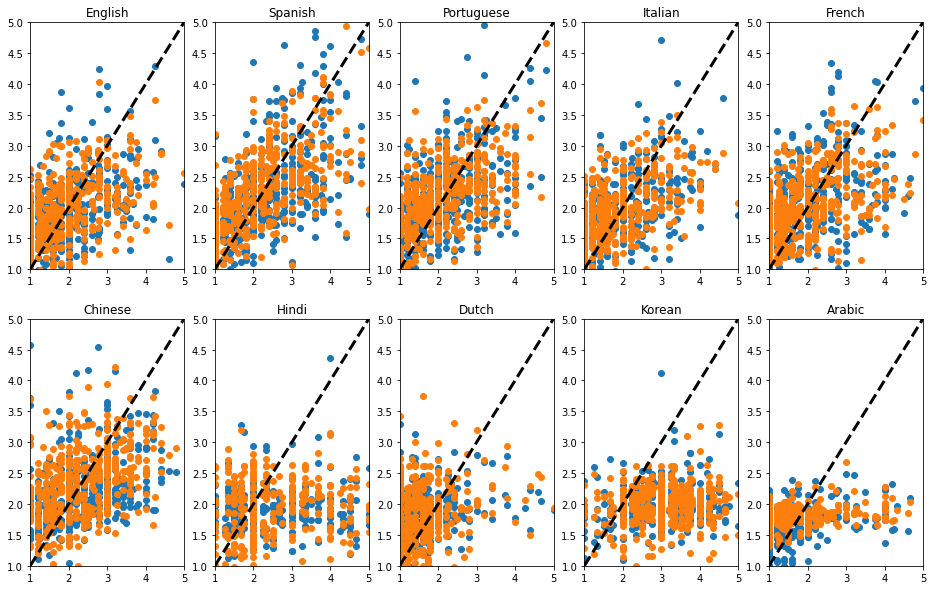

In [ ]:
f = plt.figure()
f.set_figwidth(16)
f.set_figheight(10)
i = 1

for language in languages:
  ind = (test['language'] == language).values
  plt.subplot(2,5,i)
  plt.scatter(test[ind]['label'], test[ind]['bow'])
  plt.scatter(test[ind]['label'], test[ind]['tdf-idf'])
  error = np.corrcoef(test[ind]['label'], test[ind]['predictions'])[0,1]
  plt.title(language)
  plt.xlim([1,5])
  plt.ylim([1,5])
  xpoints = ypoints = plt.xlim()
  plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
  i += 1